# OMMX Cookbook

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Jij-Inc/ommx/main?labpath=notebooks%2Fcookbook.ipynb) 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jij-Inc/ommx/blob/main/notebooks/cookbook.ipynb)

This notebook demonstrates advanced use cases of the OMMX library.

In [1]:
# To run this notebook on Colab, please uncomment following line and run this cell
# ! pip install ommx ommx-python-mip-adapter

In [2]:
from ommx.v1 import Instance, DecisionVariable, Constraint
from ommx.v1.solution_pb2 import State

## Dataframe API

OMMX has utility APIs to get decision variables and constraints as [pandas.Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). 

### Decision variable
Let's consider following informative two-dimensional decision variables:

In [3]:
n = 2
m = 3

x = [
    DecisionVariable.integer(
        m*i+j,             # ID of the decision variable, this MUST be unique
        name="x",          # Name of this decision variable
        subscripts=[i, j], # Subscript, i.e. this decision variable is `x[i, j]`
        lower=-j,          # Lower bound
        upper=2*i,         # Upper bound
        description=f"({i},{j})-th decision variable",
    )
    for i in range(n)
    for j in range(m)
]

The ID and upper and lower bounds are necessary to define the mathematical problem. In addition, `DecisionVariable` can store additional informations for pre- and post-processing:

- `name` is a human-readable name of the decision variable.
- `subscripts` is a list of integers. In many mathematical programming situations, we define multi-dimensional decision variables like $x_{ij} \in \mathbb{Z}$ for $i \in [1, n]$ and $j \in [1, m]$. OMMX requires these decision variables must be distinguished by its ID, but also allows to store its subscripts.
- `description` is a human-readable description of this decision variable

These informations are stored in `Instance` object. Let's create an empty instance with these decision variables

In [4]:
instance1 = Instance.from_components(
    decision_variables=x,
    objective=0,
    constraints=[],
    sense=Instance.MINIMIZE,
)

Then, they can be get by `decision_variables` property as a dataframe:

In [5]:
instance1.decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,integer,0.0,0.0,x,"[0, 0]","(0,0)-th decision variable",<NA>
1,integer,-1.0,0.0,x,"[0, 1]","(0,1)-th decision variable",<NA>
2,integer,-2.0,0.0,x,"[0, 2]","(0,2)-th decision variable",<NA>
3,integer,0.0,2.0,x,"[1, 0]","(1,0)-th decision variable",<NA>
4,integer,-1.0,2.0,x,"[1, 1]","(1,1)-th decision variable",<NA>
5,integer,-2.0,2.0,x,"[1, 2]","(1,2)-th decision variable",<NA>


There is another property, `parameters` of type `dict[str, str]` in `DecisionVariable` class. This is designed to use more complicated case, for example, the decision variables are labeled by the city name:

In [6]:
y = [
    DecisionVariable.binary(
        id,
        parameters={"place": place},
    )
    for id, place in enumerate(["tokyo", "kyoto", "tiba", "siga", "saga"])
]

This yields a dataframe with two-level columns:

In [7]:
Instance.from_components(
    decision_variables=y,
    objective=0,
    constraints=[],
    sense=Instance.MINIMIZE,
).decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value,parameters.place
id,,,,,,,,
0,binary,0.0,1.0,<NA>,[],<NA>,<NA>,tokyo
1,binary,0.0,1.0,<NA>,[],<NA>,<NA>,kyoto
2,binary,0.0,1.0,<NA>,[],<NA>,<NA>,tiba
3,binary,0.0,1.0,<NA>,[],<NA>,<NA>,siga
4,binary,0.0,1.0,<NA>,[],<NA>,<NA>,saga


### Constraint

Similar API exists for constraints. Since the constraints are created by comparison operators, there are method-chain style API like following:

In [8]:
z = [
    DecisionVariable.integer(i, lower=-i, upper=i)
    for i in range(5)
]

constraints = [
    (z[k+1] - z[k] <= 3)
        .add_name("difference")
        .add_subscripts([k])
    for k in range(len(z)-1)
]

Or equivalent constructor is also exists:

In [9]:
_constraints = [
    Constraint(
        function=z[k+1] - z[k] - 3,
        equality=Constraint.LESS_THAN_OR_EQUAL_TO_ZERO,
        name="difference",
        subscripts=[k],
    )
    for k in range(len(z)-1)
]

These are gathered into an `Instance`

In [10]:
instance = Instance.from_components(
    decision_variables=z,
    objective=0,
    constraints=constraints,
    sense=Instance.MINIMIZE
)

And then `Instance.constraints` property returns dataframe including these metadata:

In [11]:
instance.constraints

,equality,type,used_ids,name,subscripts,description
id,,,,,,
0,<=0,linear,"{0, 1}",difference,[0],<NA>
1,<=0,linear,"{1, 2}",difference,[1],<NA>
2,<=0,linear,"{2, 3}",difference,[2],<NA>
3,<=0,linear,"{3, 4}",difference,[3],<NA>


There is also a `parameters` field like `DecisionVariable` for string valued parameters:

In [12]:
Instance.from_components(
    decision_variables=z,
    objective=0,
    constraints=[
        (z[k+1] - z[k] <= 3)
            .add_name("difference")
            .add_parameters({ "k": str(k) })
        for k in range(len(z)-1)
    ],
    sense=Instance.MINIMIZE
).constraints

,equality,type,used_ids,name,subscripts,description,parameters.k
id,,,,,,,
8,<=0,linear,"{0, 1}",difference,[],<NA>,0
9,<=0,linear,"{1, 2}",difference,[],<NA>,1
10,<=0,linear,"{2, 3}",difference,[],<NA>,2
11,<=0,linear,"{3, 4}",difference,[],<NA>,3


### Solution

These metadata of decision variables and constraints are inherited to `ommx.v1.Solution` via `Instance.evaluation`. First, let's create an example instance:

In [13]:
instance = Instance.from_components(
    decision_variables=[
        DecisionVariable.integer(
            i,
            lower=-i,
            upper=i,
            name="z",
            subscripts=[i],
        )
        for i in range(5)
    ],
    constraints=[
        (z[k+1] - z[k] <= 3)
            .add_name("difference")
            .add_subscripts([k])
        for k in range(len(z)-1)
    ],
    objective=0,
    sense=Instance.MINIMIZE
)

In [14]:
instance.decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,integer,0.0,0.0,z,[0],<NA>,<NA>
1,integer,-1.0,1.0,z,[1],<NA>,<NA>
2,integer,-2.0,2.0,z,[2],<NA>,<NA>
3,integer,-3.0,3.0,z,[3],<NA>,<NA>
4,integer,-4.0,4.0,z,[4],<NA>,<NA>


In [15]:
instance.constraints

,equality,type,used_ids,name,subscripts,description
id,,,,,,
12,<=0,linear,"{0, 1}",difference,[0],<NA>
13,<=0,linear,"{1, 2}",difference,[1],<NA>
14,<=0,linear,"{2, 3}",difference,[2],<NA>
15,<=0,linear,"{3, 4}",difference,[3],<NA>


Then, let's create an state manually for demonstration. Note that `State` or `Solution` itself should be obtained from solvers.

In [16]:
state = State(entries={
    0: 1,
    1: 0,
    2: 0,
    3: 3,
    4: 2,
})
solution = instance.evaluate(state)

There are `decision_variables` and `constraints` properties also in `Solution` class as following. Different from `Instance` one, this contains `value` columns which contains the value in `State` for decision variables and the evaluated value of the constraint:

In [17]:
solution.decision_variables

,kind,value,lower,upper,name,subscripts,description
,,,,,,,
id,,,,,,,
0,integer,1.0,0.0,0.0,z,[0],
1,integer,0.0,-1.0,1.0,z,[1],
2,integer,0.0,-2.0,2.0,z,[2],
3,integer,3.0,-3.0,3.0,z,[3],
4,integer,2.0,-4.0,4.0,z,[4],


In [18]:
solution.constraints

,equality,value,used_ids,name,subscripts,description
,,,,,,
id,,,,,,
12,<=0,-4.0,"{0, 1}",difference,[0],
13,<=0,-3.0,"{1, 2}",difference,[1],
14,<=0,0.0,"{2, 3}",difference,[2],
15,<=0,-4.0,"{3, 4}",difference,[3],


## Dependency graph between decision variables and constraints

As shown in above examples, `constraints` contains used decision variable IDs. We can write a network graph to visualize the connection between decision variables and constrains.

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
vs = solution.decision_variables
cs = solution.constraints

G = nx.DiGraph()
G.add_nodes_from((0, id) for id in vs.index)
G.add_nodes_from((1, id) for id in cs.index)
G.add_edges_from(
    ((1, cid), (0, vid))
    for cid in cs.index
    for vid in cs["used_ids"][cid]
)

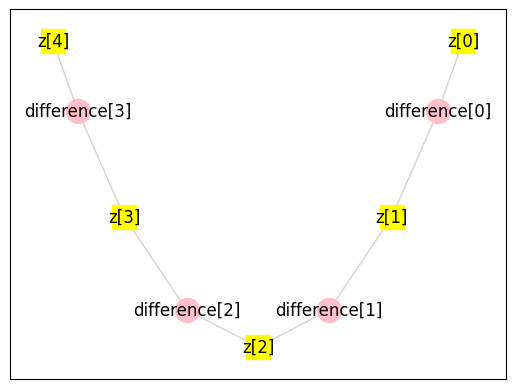

In [21]:
pos = nx.spectral_layout(G)

# Draw decision variables as red squares
nx.draw_networkx_nodes(G, pos, nodelist=[(ty, id) for ty, id in G.nodes() if ty == 0], node_color='yellow', node_shape='s')

# Draw constraints as blue circles
nx.draw_networkx_nodes(G, pos, nodelist=[(ty, id) for ty, id in G.nodes() if ty == 1], node_color='pink', node_shape='o')

# The dependencies from constraints to decision variables are shown as gray edges
nx.draw_networkx_edges(G, pos, arrows=False, edge_color='lightgray')

def label(ty, id):
    if ty == 0:
        name = vs["name"][id]
        subscripts = vs["subscripts"][id]
        return f"{name}{subscripts}"
    else:
        name = cs["name"][id]
        subscripts = cs["subscripts"][id]
        return f"{name}{subscripts}"
        
labels = {(ty, id): label(ty, id) for (ty, id) in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)

plt.show()